In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from app.utils import get_datasets
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

2024-06-23 21:47:41.793 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.794 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.795 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.796 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.797 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.798 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.798 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:41.799 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-06-

In [2]:
%matplotlib inline

In [3]:
datasets = get_datasets()

2024-06-23 21:47:42.132 
  command:

    streamlit run /home/maciej/Projects/Code/streamlit-app/.venv/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-06-23 21:47:42.132 No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:42.136 No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:42.138 No runtime found, using MemoryCacheStorageManager
2024-06-23 21:47:42.139 No runtime found, using MemoryCacheStorageManager


In [4]:
clusters = list(range(1, 20))

In [5]:
def validate_k_means_parameter(dataset: tuple[np.ndarray, np.ndarray], clusters: list[int], metric) -> np.ndarray:
    result = []
    X_train, X_val, _, y_val = train_test_split(dataset[0], dataset[1], test_size=0.3, random_state=0)
    for k in clusters:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X_train)
        y_hat = kmeans.predict(X_val)
        result.append(metric(y_val, y_hat))
    
    return np.array(result)

In [6]:
def compute_wcss_k_means(dataset: tuple[np.ndarray, np.ndarray], clusters: list[int]) -> list[int]:
    wcss = []
    for k in clusters:
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(dataset[0])
        wcss.append(model.inertia_)
    
    return wcss

In [7]:
def compute_silhouette_dbscan(dataset: tuple[np.ndarray, np.ndarray], epss: list[int], min_ptss: list[int]) -> list[int]:
    score = []
    X = dataset[0]
    for eps, min_pts in zip(epss, min_ptss):
        model = DBSCAN(eps=eps, min_samples=min_pts)
        labels = model.fit_predict(X)
        score.append(silhouette_score(X, labels))
    
    return score

In [8]:
def plot_silhouette_dbscan(datasets: tuple[np.ndarray, np.ndarray], epss: dict[str, list[int]], min_ptss: dict[str, list[int]]) -> None:
    n_cols = 3
    n_rows = int(np.ceil(len(datasets) / n_cols))
    figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
    axis_flatten = axis.flatten()
    for i, (name, dataset) in enumerate(datasets.items()):
        data_to_plot = compute_silhouette_dbscan(dataset, epss[name], min_ptss[name])
        axis_flatten[i].plot(min_ptss[name], data_to_plot)
        axis_flatten[i].set_title(name, fontsize='x-large')
        axis_flatten[i].set_ylabel('silhouette score', fontsize='medium')
        axis_flatten[i].set_xlabel('MinPts', fontsize='medium')
        axis_flatten[i].set_xticks(min_ptss[name])
        
    figure.suptitle('Silhouette Score for Different MinPts Values', fontsize=18, y=1.01)
    figure.tight_layout()
    figure.show()

In [9]:
epss = {
    'moons': np.linspace(0.03, 0.08, num=5),
    'rings': np.linspace(0.1, 0.2, num=5),
    'blobs': np.linspace(0.03, 0.07, num=5),
    'uniformly distributed': np.linspace(0.075, 0.15, num=5),
    'different densities': np.linspace(0.08, 0.18, num=5),
    'nested clusters': np.linspace(0.07, 0.016, num=5),
}

min_ptss = {name: np.arange(3, 8) for name in datasets}

In [10]:
np.linspace(0.07, 0.16, num=5)

array([0.07  , 0.0925, 0.115 , 0.1375, 0.16  ])

/tmp/ipykernel_34194/401960781.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


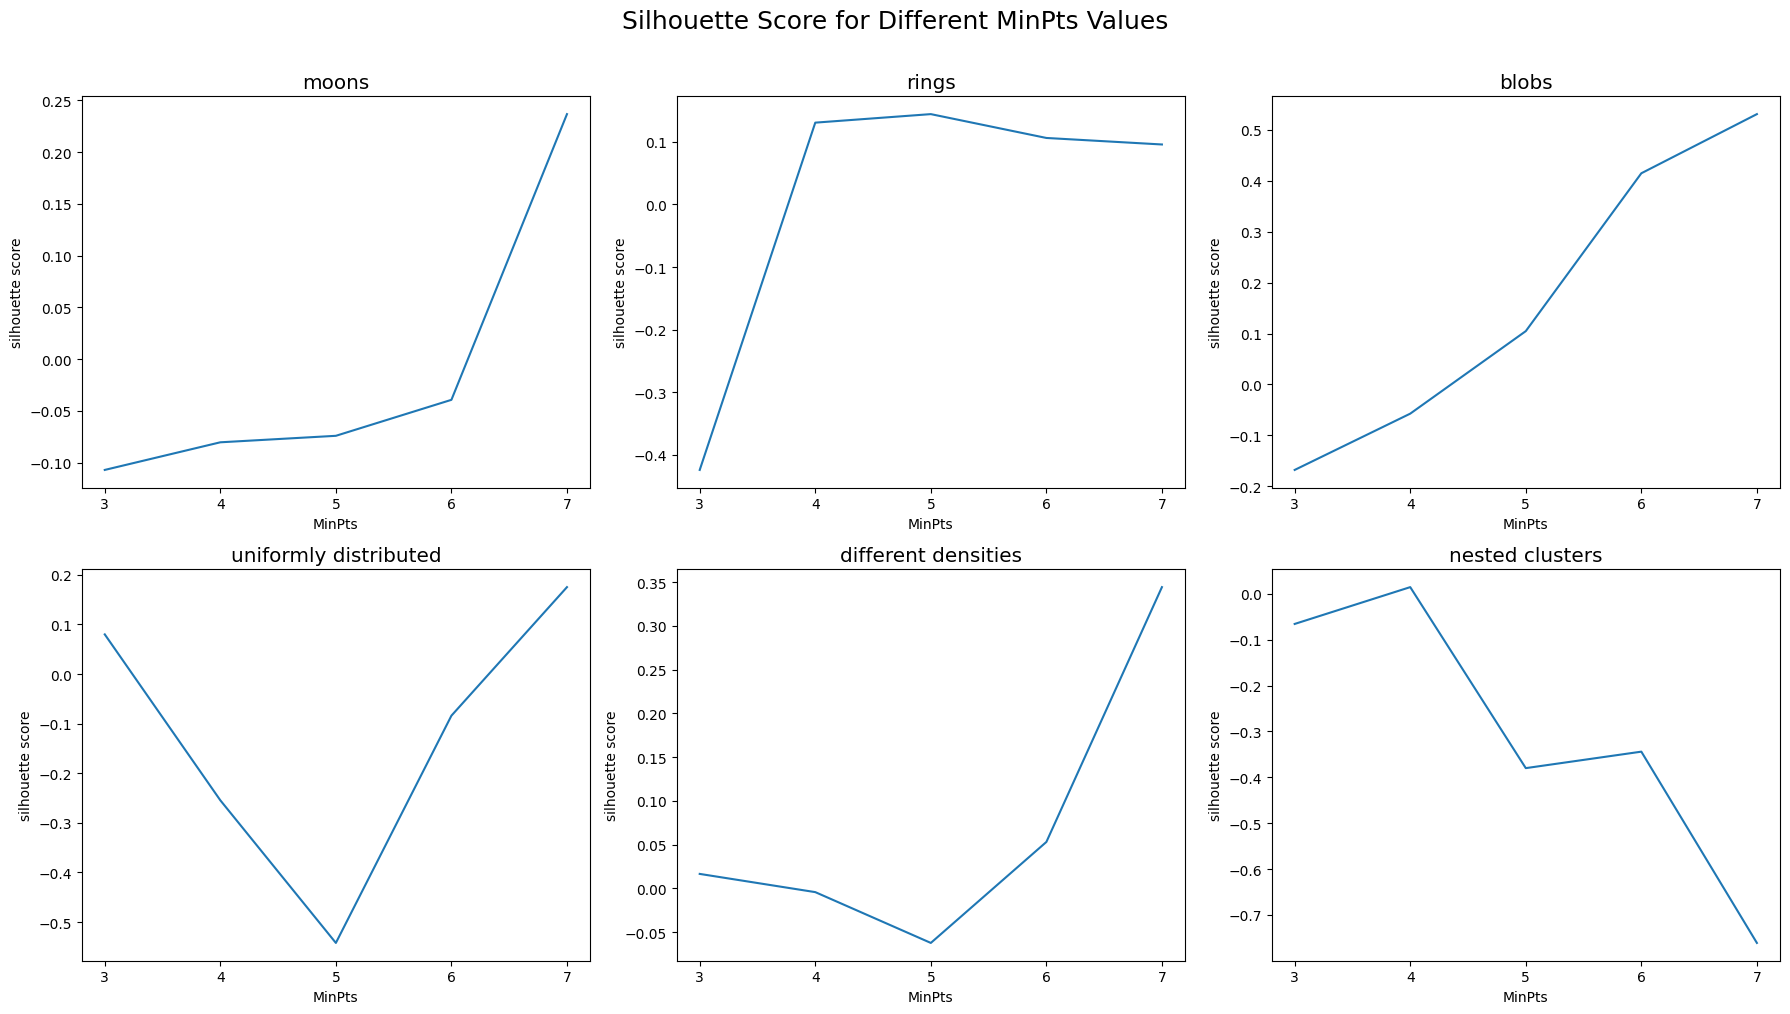

In [11]:
plot_silhouette_dbscan(datasets, epss, min_ptss)

In [12]:
def compute_kth_nearest_neighbours(dataset: tuple[np.ndarray, np.ndarray], min_ptss: list[int]) -> list[np.ndarray]:
    X, _ = dataset
    result = []
    for k in min_ptss:
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(X)
        distances, _ = neighbors_fit.kneighbors(X)
        result.append(np.sort(distances[:, k-1], axis=0))
    
    return result

In [13]:
hierarchical_methods = {
    'moons': 'single',
    'rings': 'ward',
    'blobs': 'ward',
    'uniformly distributed': 'ward',
    'different densities': 'ward',
    'nested clusters': 'ward',
}

In [14]:
def plot_dendrograms(datasets: tuple[np.ndarray, np.ndarray]) -> None:
    n_cols = 3
    n_rows = int(np.ceil(len(datasets) / n_cols))
    figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
    axis_flatten = axis.flatten()
    for i, (name, dataset) in enumerate(datasets.items()):
        Z = linkage(dataset[0], method=hierarchical_methods[name], metric='euclidean')
        dendrogram(Z, ax=axis_flatten[i], truncate_mode='lastp', p=50)
        axis_flatten[i].set_ylabel('distance', fontsize='medium')
        axis_flatten[i].set_title(f'{name} ({hierarchical_methods[name]} linkage)', fontsize='x-large')
        axis_flatten[i].set_xticks([])
    
    figure.suptitle('Dendrograms', fontsize=18, y=1.01)
    figure.tight_layout()
    figure.show()

/tmp/ipykernel_34194/1250321729.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


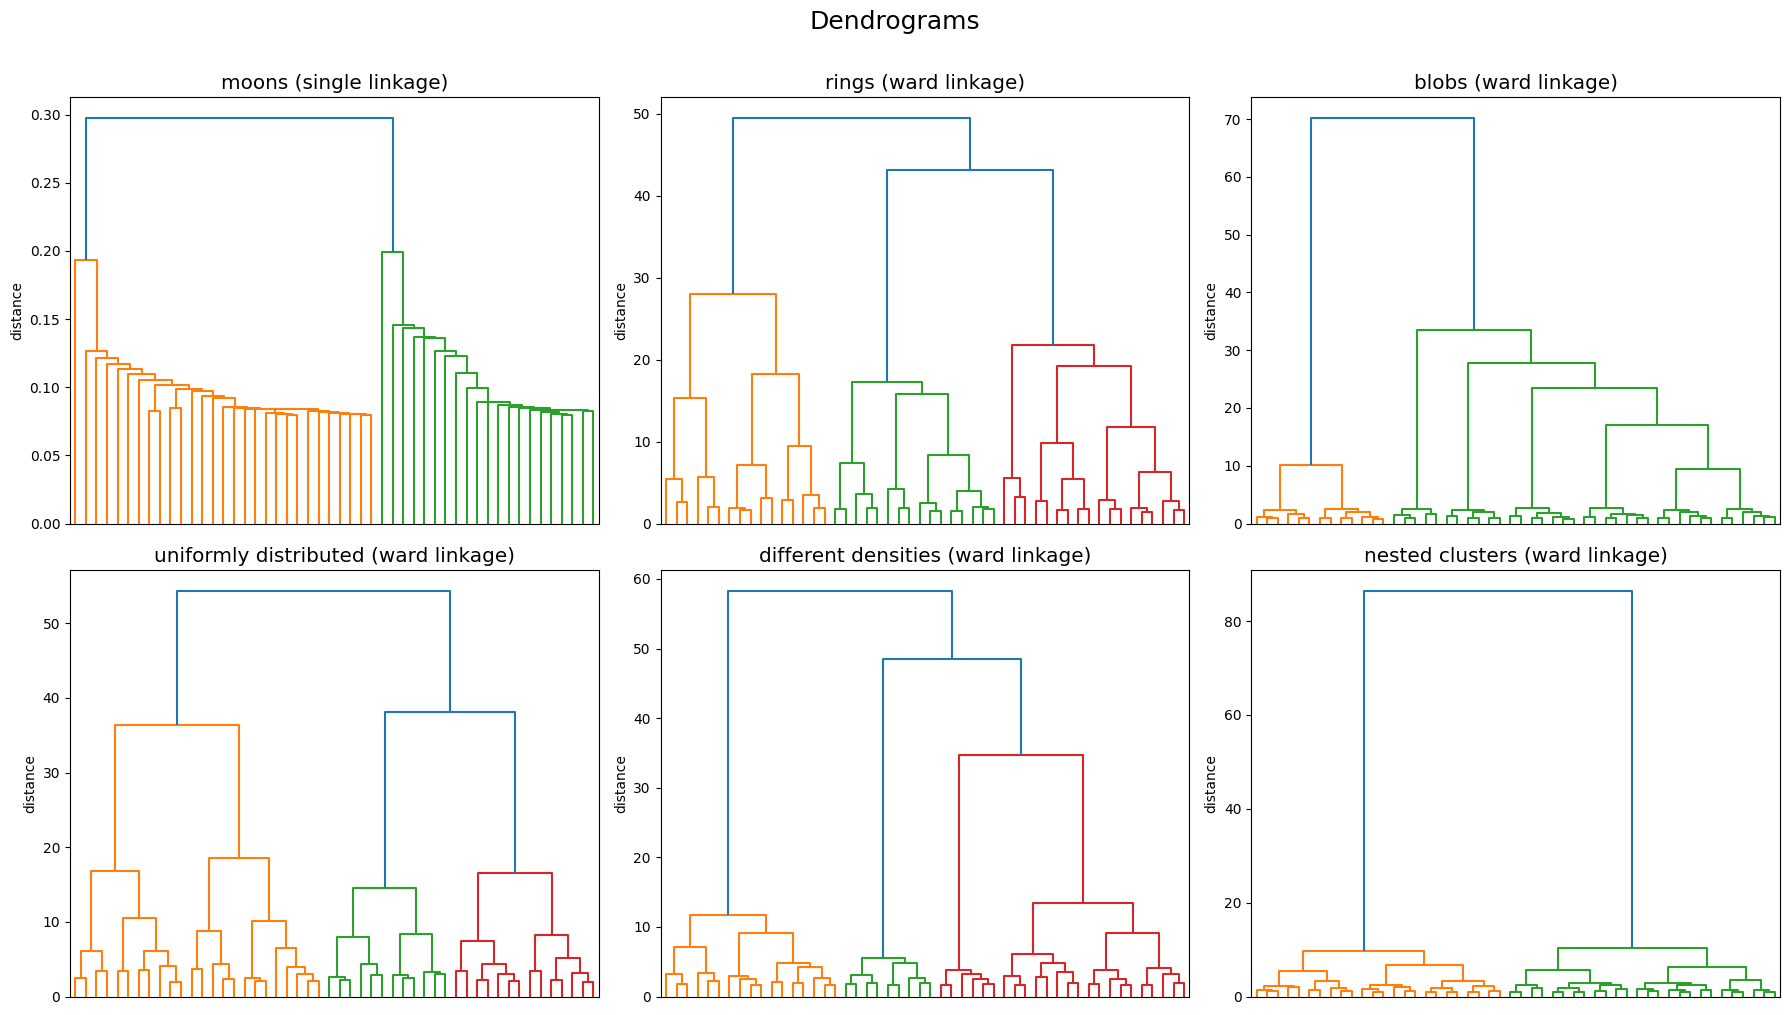

In [15]:
plot_dendrograms(datasets)

In [16]:
def plot_metric(datasets, clusters, metric, metric_name, title, plot_type: str = 'plot', mark_max: bool = False) -> None:
    n_cols = 3
    n_rows = int(np.ceil(len(datasets) / n_cols))
    figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
    figure.subplots_adjust(top=0.8)
    axis_flatten = axis.flatten()
    for i, (name, dataset) in enumerate(datasets.items()):
        X = metric(dataset, clusters)
        if plot_type == 'plot':
            axis_flatten[i].plot(clusters, X)
        elif plot_type == 'scatter':
            axis_flatten[i].scatter(x=clusters, y=X)
        if mark_max:
            axis_flatten[i].plot(clusters[np.argmax(X)], X.max(), 'rx', markersize=8)
            axis_flatten[i].axvline(x=np.argmax(X) + 1, ls='--', color='gray')
        axis_flatten[i].set_title(name, fontsize='x-large')
        axis_flatten[i].set_ylabel(metric_name, fontsize='medium')
        axis_flatten[i].set_xlabel('Number of clusters', fontsize='medium')
        axis_flatten[i].set_xticks(clusters)
        
    figure.suptitle(title, fontsize=18, y=1.01)
    figure.tight_layout()
    figure.show()

In [17]:
def plot_system(datasets: dict[str, tuple[np.ndarray, np.ndarray]], param: list[int], F, xaxis: str, yaxis: str, title: str) -> None:
    n_cols = 3

    n_rows = int(np.ceil(len(datasets) / n_cols))
    figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
    figure.subplots_adjust(top=0.8)
    axis_flatten = axis.flatten()
    for i, (name, dataset) in enumerate(datasets.items()):
        for k, data in zip(param, F(dataset, param)):
            axis_flatten[i].plot(data, label=k)
        axis_flatten[i].set_title(name, fontsize='x-large')
        axis_flatten[i].set_xlabel(xaxis, fontsize='medium')
        axis_flatten[i].set_ylabel(yaxis, fontsize='medium')
        axis_flatten[i].legend()
    
    figure.suptitle(title, fontsize=18, y=1.01)
    figure.tight_layout()
    figure.show()

## Datasets plotting

/tmp/ipykernel_34194/4216808785.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


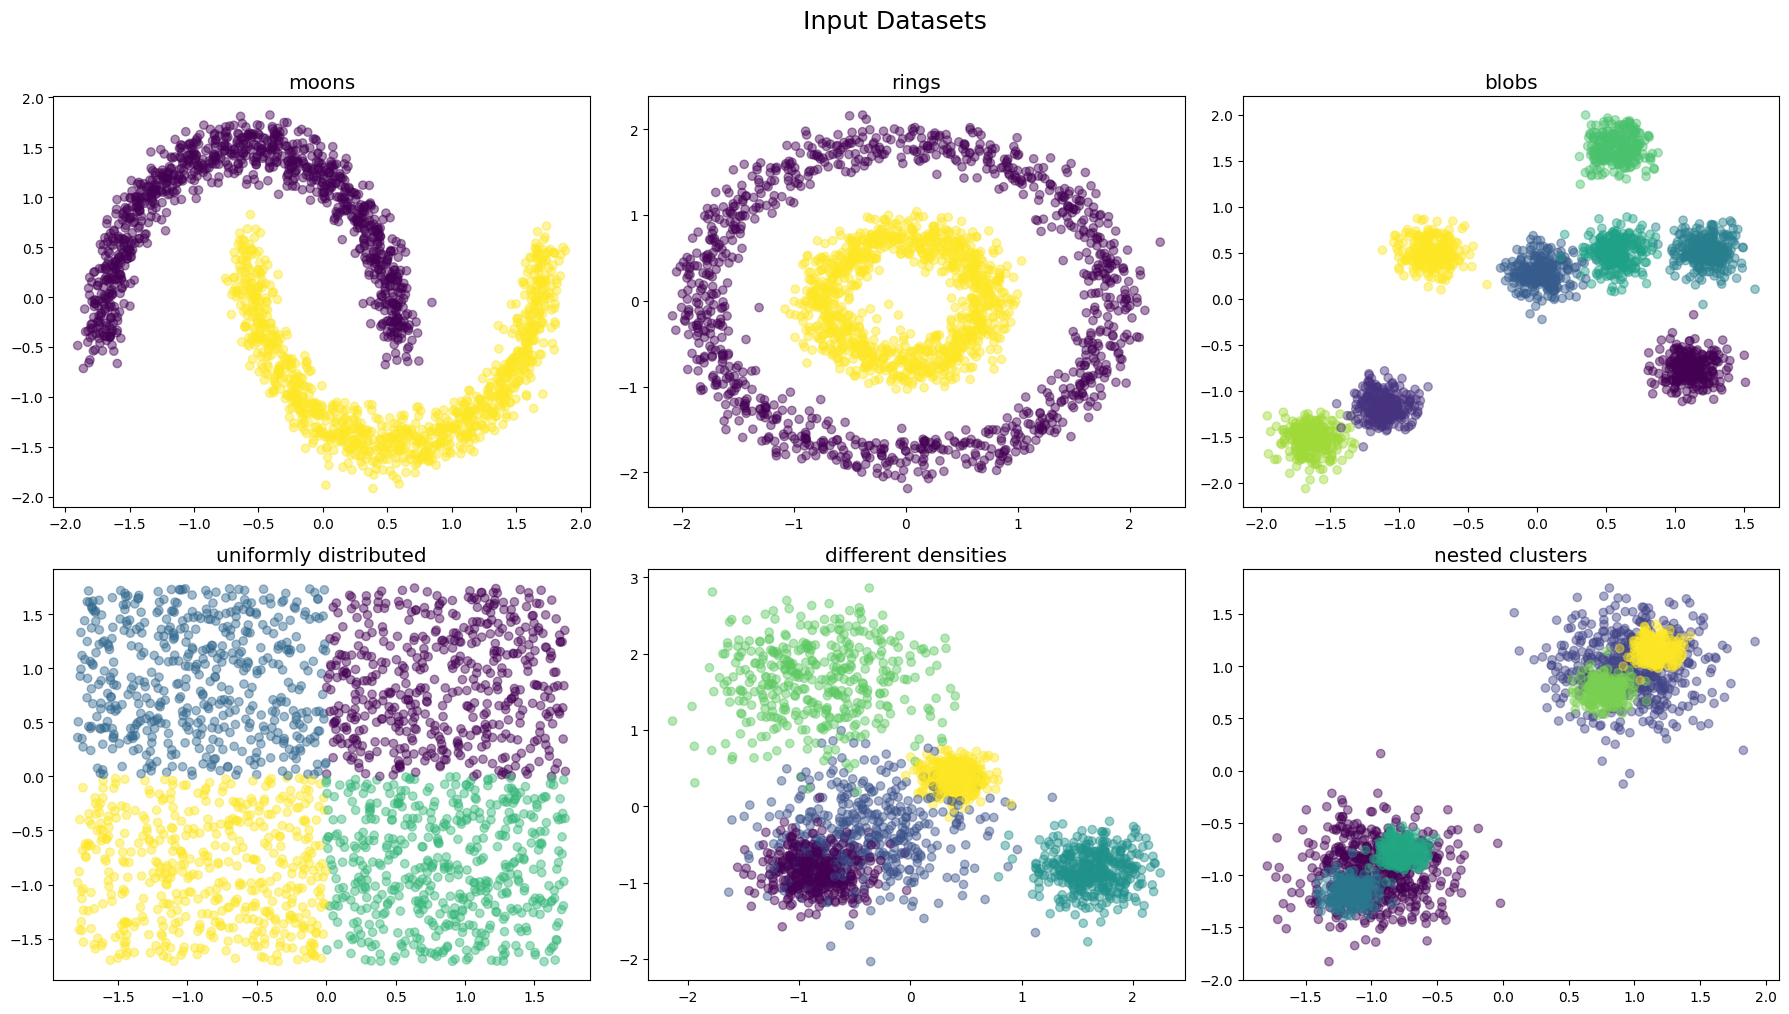

In [18]:
n_cols = 3
n_rows = int(np.ceil(len(datasets) / n_cols))
figure, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))
axis_flatten = axis.flatten()
for i, (name, dataset) in enumerate(datasets.items()):
    data, labels = dataset
    axis_flatten[i].scatter(x=data[:, 0], y=data[:, 1], c=labels, alpha=0.45, cmap='viridis')
    axis_flatten[i].set_title(f'{name}', fontsize='x-large')

figure.suptitle('Input Datasets', fontsize=18, y=1.01)
figure.tight_layout()
figure.show()

## Estimating parameters for KMeans clustering

todo KMeans k parameter should be determined in the following way

1. split the data into validation and training set
2. perform k-means (fit the model) into validation set
3. evaluate chosen metrics

In [19]:
clusters = list(range(1, 20))

/tmp/ipykernel_34194/2811495375.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


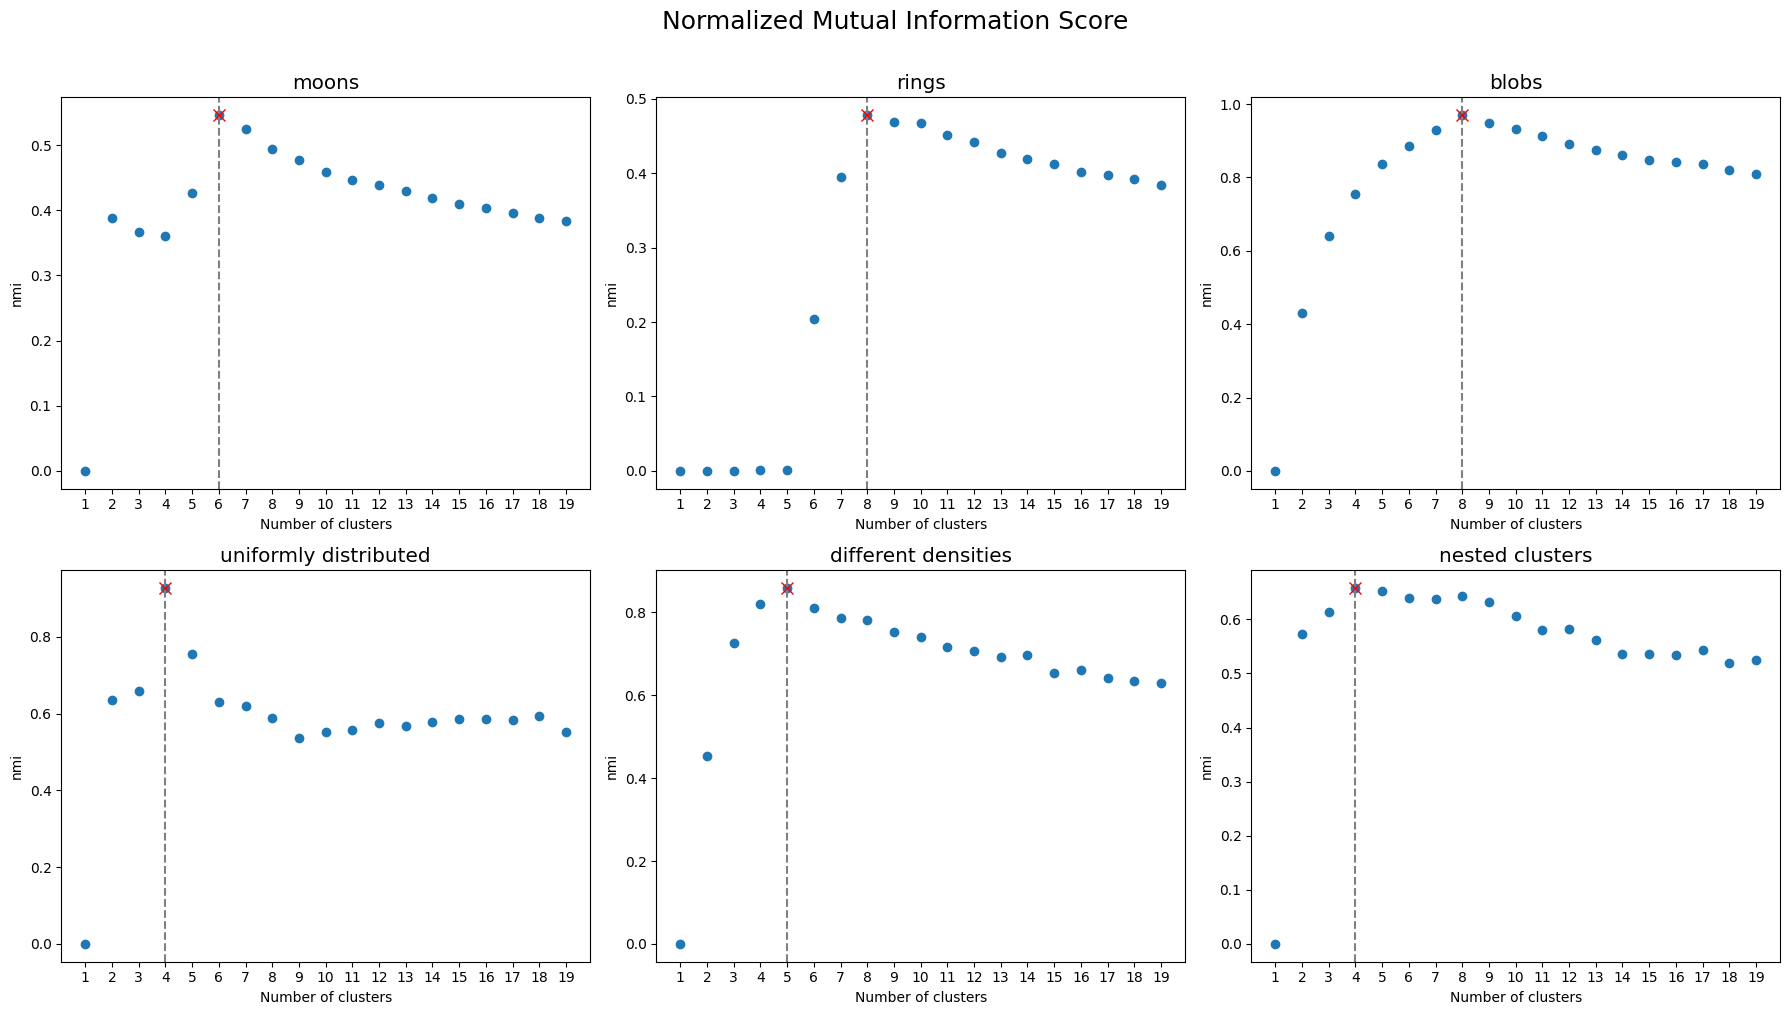

In [20]:
plot_metric(
    datasets=datasets, 
    clusters=clusters, 
    metric=lambda dataset, params: validate_k_means_parameter(dataset, params, normalized_mutual_info_score),
    metric_name='nmi',
    title='Normalized Mutual Information Score',
    plot_type='scatter',
    mark_max=True,
)

/tmp/ipykernel_34194/2811495375.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


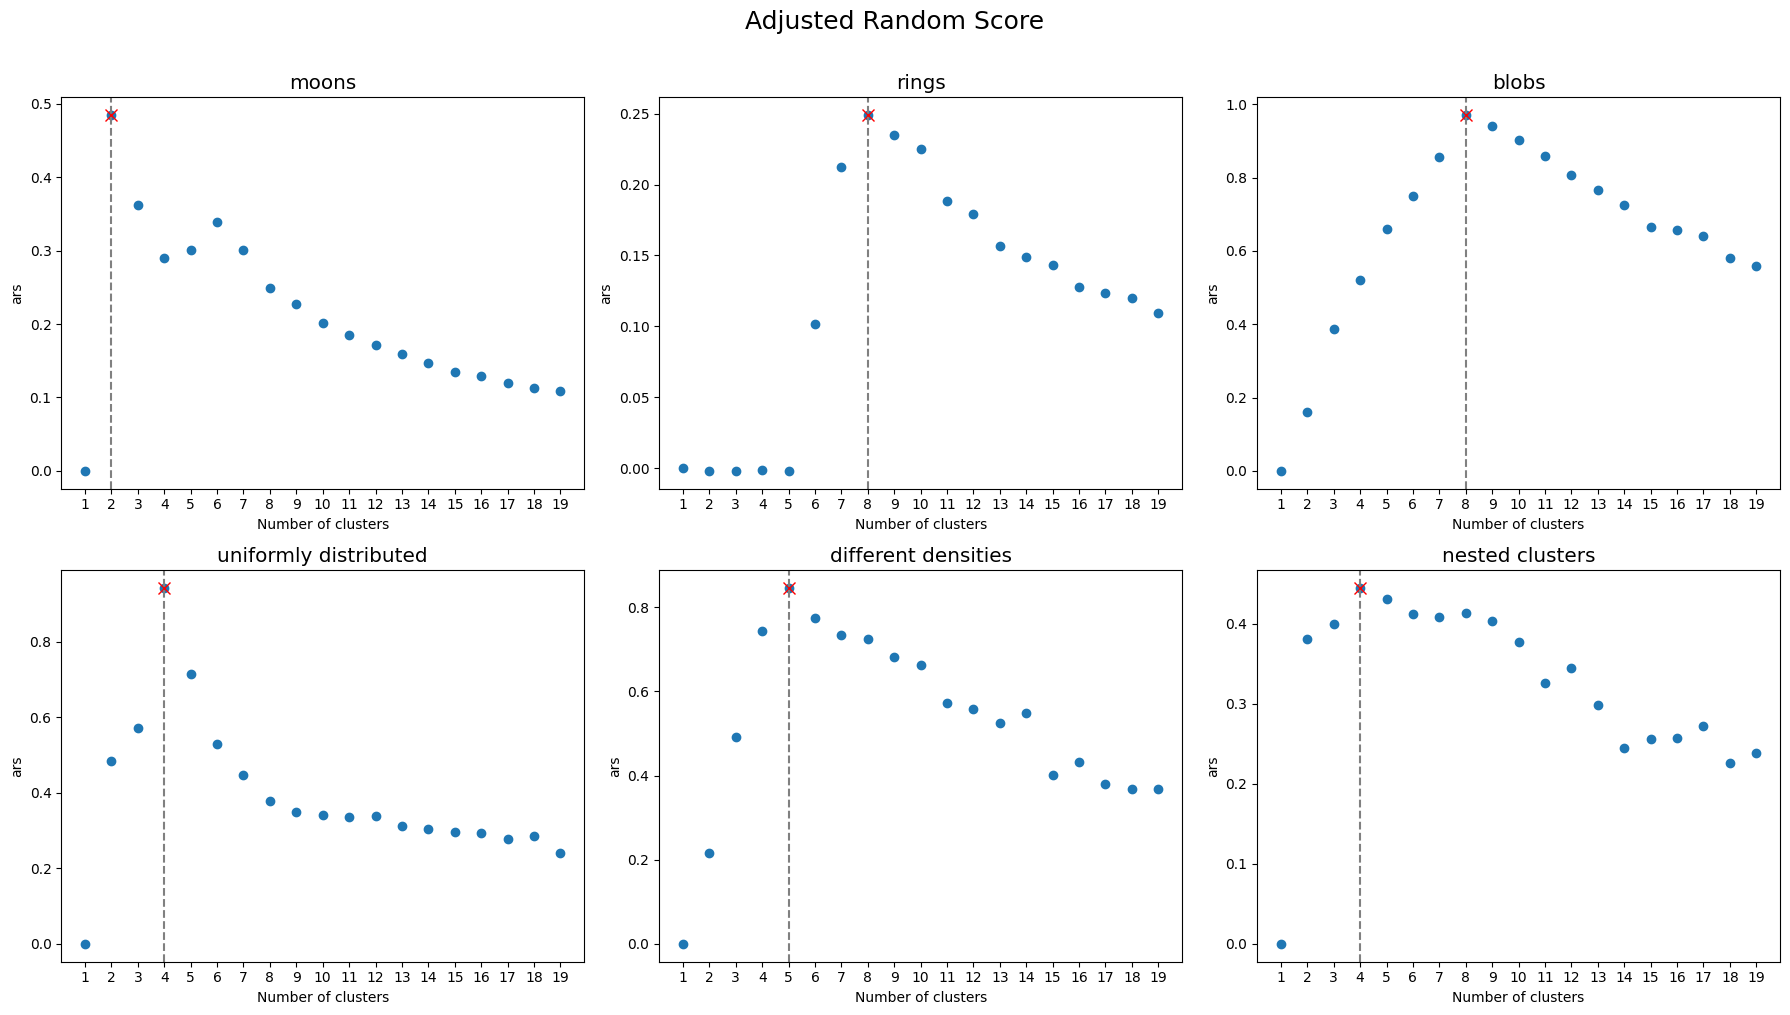

In [21]:
plot_metric(
    datasets=datasets, 
    clusters=clusters, 
    metric=lambda dataset, params: validate_k_means_parameter(dataset, params, adjusted_rand_score),
    metric_name='ars',
    title='Adjusted Random Score',
    plot_type='scatter',
    mark_max=True,
)

/tmp/ipykernel_34194/2811495375.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


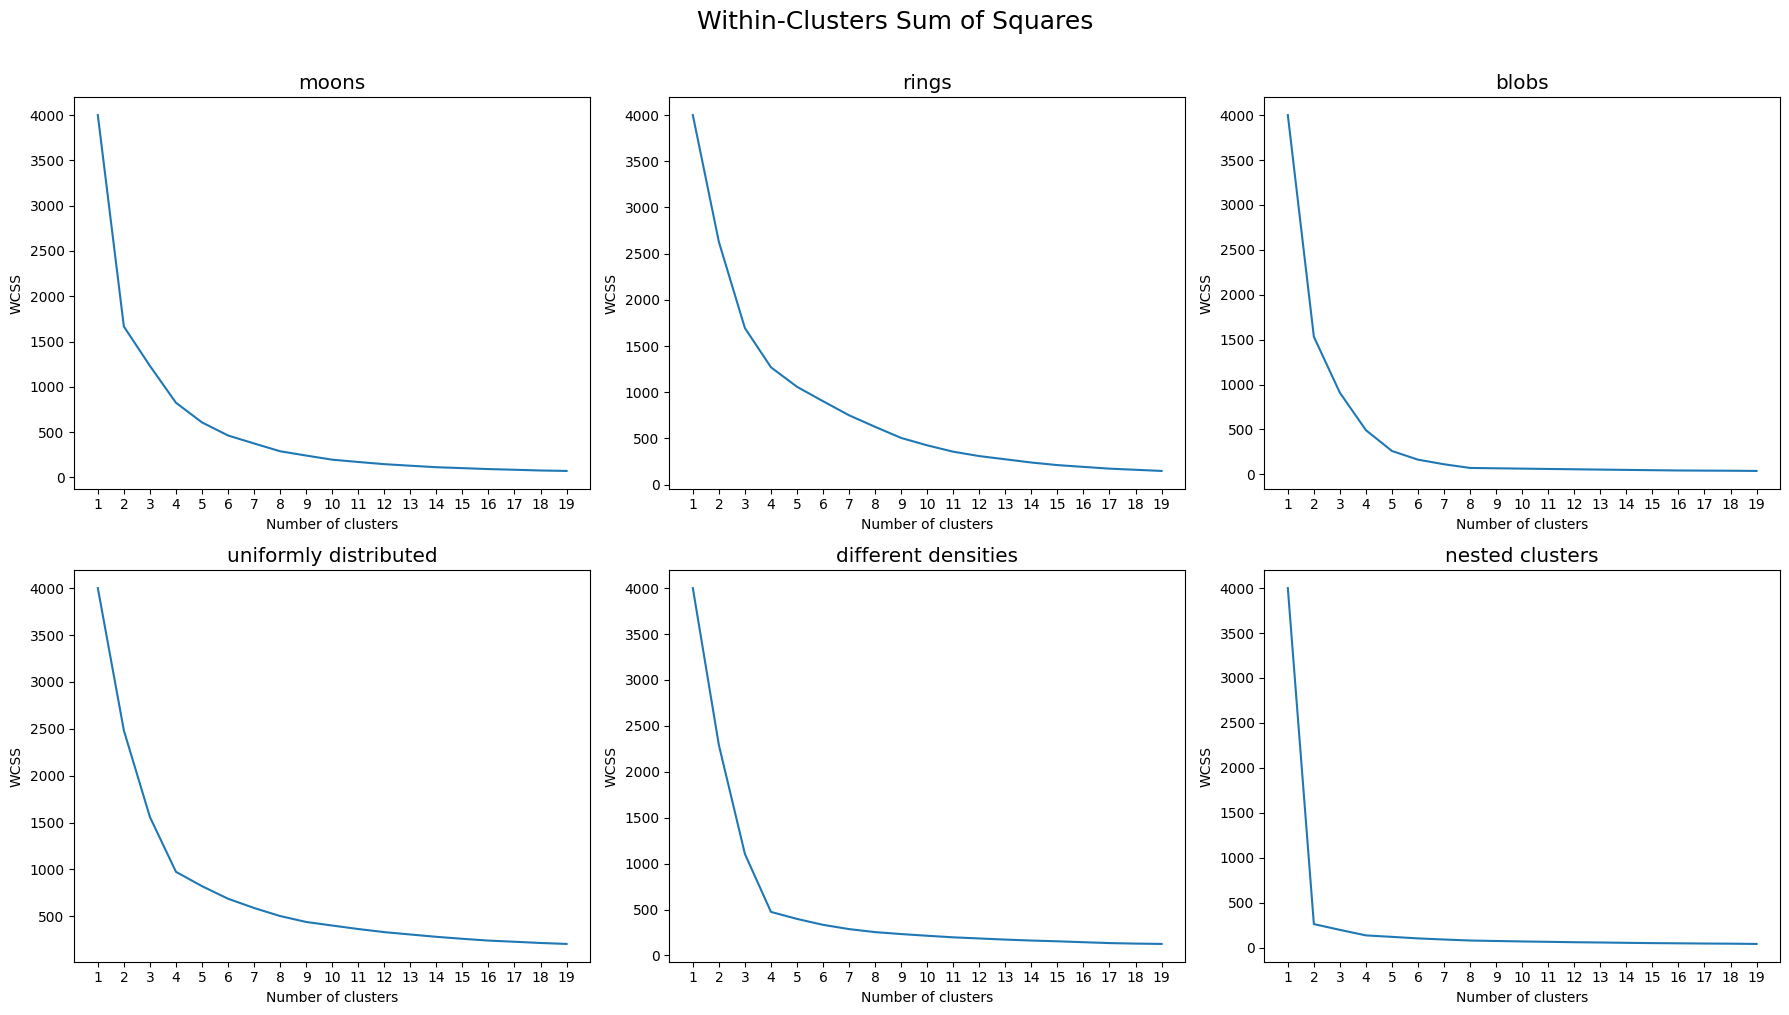

In [22]:
plot_metric(datasets, clusters, compute_wcss_k_means, 'WCSS', 'Within-Clusters Sum of Squares')

## Estimating parameters of DB SCAN clustering

In [23]:
ptss_consideration = [3, 4, 5, 6]

/tmp/ipykernel_34194/1482569320.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


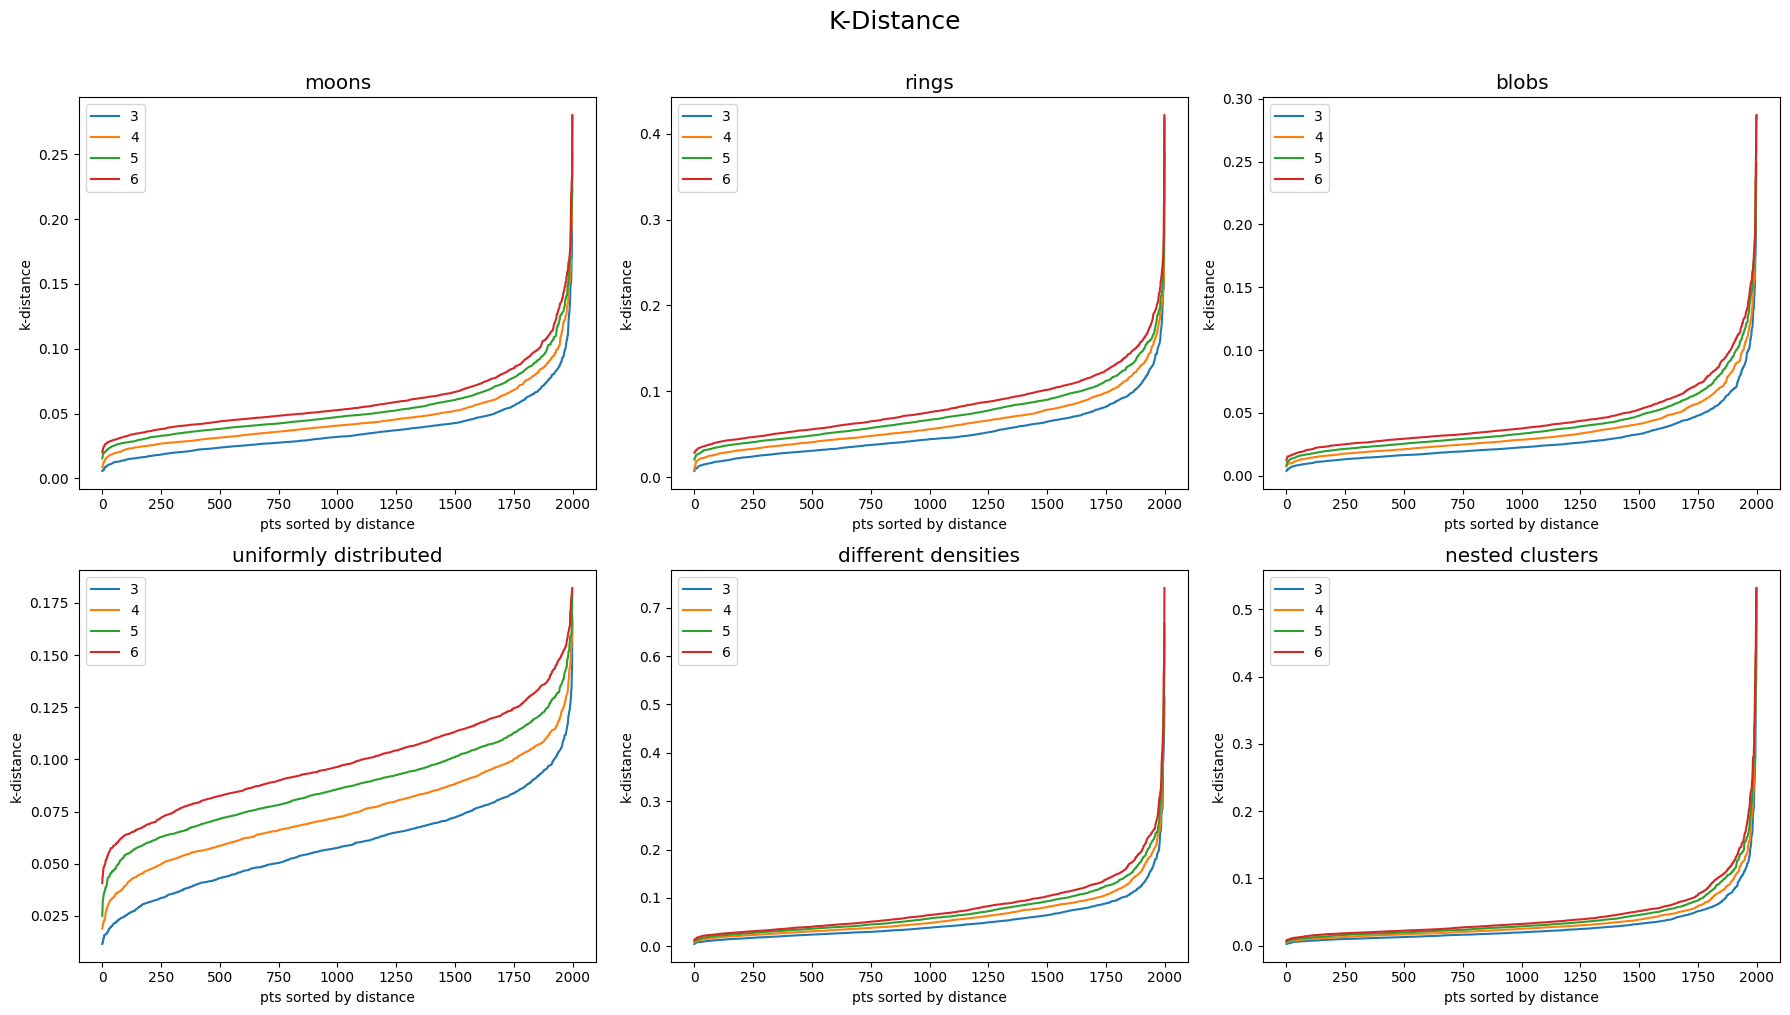

In [24]:
plot_system(datasets, ptss_consideration, compute_kth_nearest_neighbours, xaxis='pts sorted by distance', yaxis='k-distance', title='K-Distance')

## Estimating parameters of hierarchical clustering

/tmp/ipykernel_34194/1250321729.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


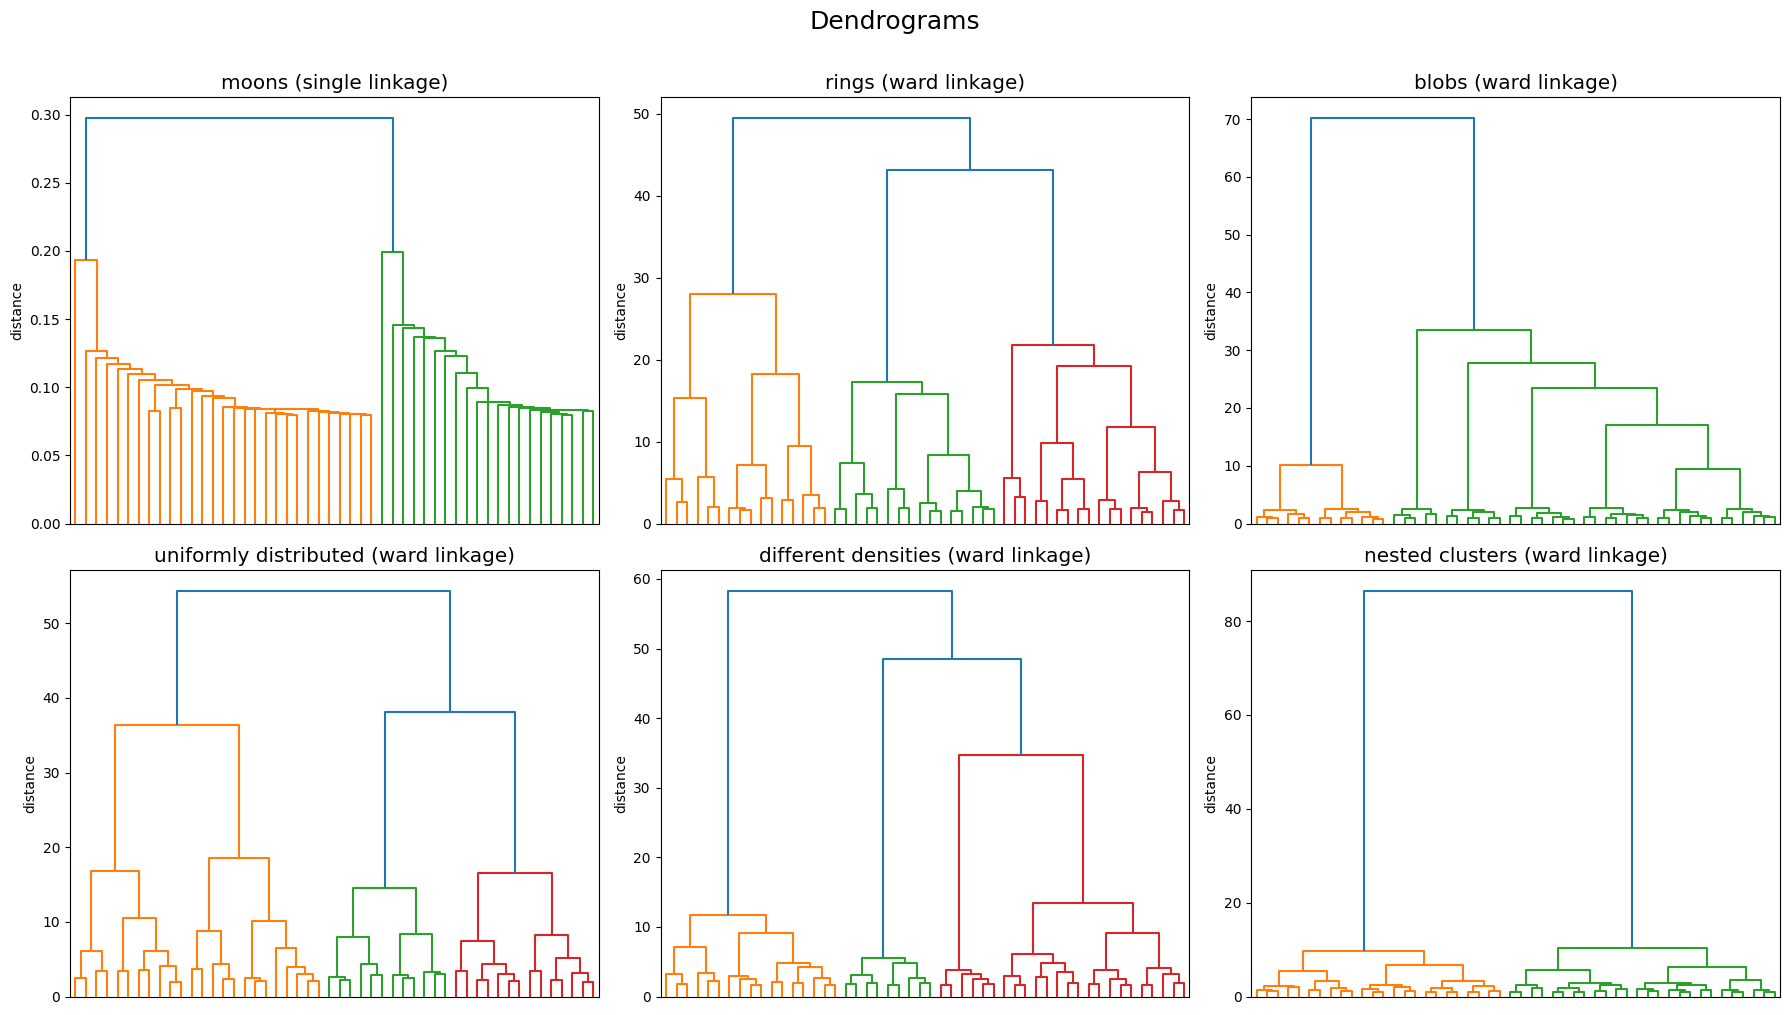

In [25]:
plot_dendrograms(datasets)